In [3]:
import pandas as pd
import wordcloud
import numpy as np
import seaborn as sn
import string
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
import pickle

In [4]:
pd.set_option('display.max_colwidth', None)

## Read data from Lithosphere

In [5]:
DATA_PATH="/Users/jyotsana.j/lithium/checkouts/dataset/"
columns = ["messageId","threadId","parentId","creationTime","subject","body","language","nodePath","nodeStyle","userId","userRank","tags","labels","spamMarkUser","notMarkedAsSpam","uri","spam"]
nonsignificantcolumns =["messageId","threadId","parentId","language","creationTime","nodePath","uri"]

Read data from lithosphere csv

In [6]:
lithodata = pd.read_csv(DATA_PATH + "lithosphere.spam2.csv", usecols=columns)
lithodata=lithodata.drop(columns=nonsignificantcolumns)
lithodata.shape

(174030, 10)

Read data from opensource

In [7]:
sampledata = pd.read_csv(DATA_PATH + "open_spam_data.csv")
sampledata.shape

(30024, 2)

Convert label from boolean to 1.0 and 0.0

In [8]:
df1 = lithodata.select_dtypes(include=[bool])
booleanDictionary = {True: 1.0, False: 0.0}

for column in df1:
    lithodata[column] = lithodata[column].map(booleanDictionary)

Convert lithosphere data into text and spam columns

In [9]:
lithodf=pd.DataFrame()
lithodf['text']=lithodata["subject"].str.cat(lithodata[["body", "userId", "userRank"]].astype(str), sep=" ")
lithodf['spam']=lithodata['spam']

In [10]:
lithodf

,text,spam
0,"Re: Do You Empower or Influence? <p>Micheal Wu,</p><p> </p><p>My issue revolves around how both empowerment and influence are being used at the corporate level. And you pointed this out in the good and bad portion of your article. I am a communication graduate but not a (Ph.d). I believe empowerment and influence are being abused more and more at the corporate level. Copywrite from a legal perspective is at the time of inception and communication of that idea validates your right to be protected. The problem is where the key influence and empowerment is derived from and how it effects the privacy of that user. Was the information obtained legally from the originator of the idea or was it mutated with the general intent of the messages and disseminated to the internet? In the internet my concern is the growing enterprise of collecting and using information without a real depth of understanding of sources. It is like a newspaper not being able to accurately know all it's sources. I believe that corporations and users need to be more transparent in their collection and use of information. I would also like to better understand ways of protecting myself and my business. Perhaps you could direct me to some resources.</p><p> </p><p>Brian</p><p><a rel=""nofollow"" target=""_blank"" href=""http://www.synergychat.com"">www.synergychat.com</a></p><p> </p> -1 nan",0.0
1,Re: iPhone bug prevents posting to Lithium communities - please fix! Same here - updated to 4.2 and still see the bug. 209 Honored Contributor,0.0
2,"Congrats to the Top Kudo'd Authors in September <p><img src=""http://lithosphere.lithium.com/t5/image/serverpage/image-id/1256i5210ECEF6EC5686A/image-size/original?v=mpbl-1&amp;px=-1"" border=""0"" alt=""kudosSept10.png"" title=""kudosSept10.png"" align=""left"" />September blazed by at lightening speed... as did the first few days of October apparently. Congratulations to our top kudo'd authors in the Lithosphere for last month.</p>\n<p>&nbsp;</p>\n<p>The VIP council again takes the top spots, that's why they are in our MVP group, so thanks to:</p>\n<p>&nbsp;</p>\n<ol>\n<li><a href=""http://lithosphere.lithium.com/t5/user/viewprofilepage/user-id/119"" target=""_self"" rel=""nofollow"">Mark_Hopkins</a></li>\n<li><a href=""http://lithosphere.lithium.com/t5/user/viewprofilepage/user-id/248"" target=""_self"" rel=""nofollow"">Jason</a></li>\n<li><a href=""http://lithosphere.lithium.com/t5/user/viewprofilepage/user-id/50"" target=""_self"" rel=""nofollow"">Laura</a></li>\n</ol>\n<div>For all their great contributions to ideas, blogs, tkb and the forums. We couldn't run this without the efforts of people like you. Our own '<a href=""http://lithosphere.lithium.com/t5/user/viewprofilepage/user-id/102"" target=""_self"" rel=""nofollow"">SusanM</a>' was propping up 4th spot for all the great work she has been doing documenting our new features and betas in the customer blog.</div>\n<div>New on the list in 5th this month is '<a href=""http://lithosphere.lithium.com/t5/user/viewprofilepage/user-id/2828"" target=""_self"" rel=""nofollow"">prisaz</a>' - welcome to the leaderboard!!</div>\n<div>Thanks everyone.</div>\n<p>&nbsp;</p> 771 Lithium Alumni (Retired)",0.0
3,"User Guidelines <p>Thanks for joining the Lithosphere. Our usage guidelines are here to ensure that we have a fair and pleasant environment for everyone to participate in. I'd encourage you to read through.</p>\n<p>&nbsp;</p>\n<p>&nbsp;</p>\n<ul>\n<li><a href=""/t5/About-our-community/Lithium-Community-Guidelines/ta-p/134781"" target=""_self"" rel=""nofollow"">User Guidelines</a></li>\n</ul>\n<p>&nbsp;</p> 771 Lithium Alumni (Retired)",0.0
4,Re: Wanna know a Secret? <p>Greg - thanks for your note and thanks for your suggestion. Actually that makes a lot of sense and I'll work on updating that. I think a 'Previous Secret / Next Secret' style nav could be cool.</p> 771 Lithium Alumni (Retired),0.0
...,...,...
174025,"How to provision limited Studio access to deve

## Get sample from litho and open source

In [12]:
spam=pd.DataFrame(lithodf.groupby('spam').get_group(1.0))
ham=pd.DataFrame(lithodf.groupby('spam').get_group(0.0)).sample(n=30000, random_state=0)

In [13]:
spam.shape

(745, 2)

In [14]:
ham.shape

(30000, 2)

In [72]:
finalset=pd.concat([spam, ham, sampledata], ignore_index=True)

In [73]:
finalset.shape

(60769, 2)

In [74]:
finalset['spam'].value_counts()

0.0    52585
1.0     8184
Name: spam, dtype: int64

In [75]:
finalset.head()

,text,spam
0,"New Light CBD <p><br /><br /><a href=""https://www.supplementmegamart.com/new-light-cbd/"" target=""_self"">New Light CBD</a>. The BCAA supplement enhanced the muscle growth response slightly compared to a placebo, however the muscle's response was more than double when a whey protein supplement containing the equivalent amount of BCAA that included the other amino acids, was taken.|In this Muscle Building Summit Masters of Motivation highlight, Dai covers practical applications such as the importance of hormone profiling, as well as the inner issues that brought him face to face with the biggest challenges, in and out of the gym, at various stages of his life, the WHY aspect.<br /><a href=""https://www.supplementmegamart.com/new-light-cbd/"" target=""_self"">https://www.supplementmegamart.com/new-light-cbd/</a></p> 75773 New Commentator",1.0
1,의정부CAD학원Jr닷ezenac닷co.KR이젠아카데미ん의정부내일배움카드학원 의정부고용지원센터 <p>의정부CAD학원Jr닷ezenac닷co.KR이젠아카데미ん의정부내일배움카드학원 의정부고용지원센터</p> 75995 Occasional Contributor,1.0
2,의정부IT학원 エ이젠아카데미 𝒥𝑅.𝑒𝓏𝐸𝓃𝒜𝒸.𝒞𝑜.𝒦𝓇シ 의정부내일배움카드 의정부엑셀학원 <p>의정부IT학원 エ이젠아카데미 𝒥𝑅.𝑒𝓏𝐸𝓃𝒜𝒸.𝒞𝑜.𝒦𝓇シ 의정부내일배움카드 의정부엑셀학원</p> 75995 Occasional Contributor,1.0
3,이젠아카데미ぃJ̳R̳.e̳z̳E̳n̳A̳c̳.C̳o̳.K̳r̳¶의정부전산회계학원🉐의정부국비지원교육센터す의정부시컴퓨터학원 <p>이젠아카데미ぃJ̳R̳.e̳z̳E̳n̳A̳c̳.C̳o̳.K̳r̳¶의정부전산회계학원🉐의정부국비지원교육센터す의정부시컴퓨터학원</p> 75995 Occasional Contributor,1.0
4,의정부국비교육¶ＪＲ.ｅｚＥｎＡｃ.Ｃｏ.Ｋｒわ이젠아카데미エ의정부국비지원교육센터ঞ의정부엑셀학원 <p>의정부국비교육¶ＪＲ.ｅｚＥｎＡｃ.Ｃｏ.Ｋｒわ이젠아카데미エ의정부국비지원교육센터ঞ의정부엑셀학원</p> 75995 Occasional Contributor,1.0


## Preprocessing of data

In [76]:
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.stem import SnowballStemmer
import re
import nltk


lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
STOPWORDS = set(stopwords.words('english'))
snowball_stemmer = SnowballStemmer('english')

In [77]:
def tokenization(text):
    tokens = word_tokenize(text)

In [78]:
def toLower(text):
    return [sentence.lower() for sentence in text]

In [79]:
from bs4 import BeautifulSoup
def remove_html(htmlTxt):
    return [" ".join(BeautifulSoup(sentence).findAll(text=True)) for sentence in htmlTxt ]

In [80]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')        
    return [url_pattern.sub(r'', word) for word in text ]

In [81]:
def remove_stopwords(text):
    fullList=[]
    for sentence in text:
        sentence = " ".join([word for word in str(sentence).split() if word not in STOPWORDS])
        fullList.append(sentence)
    return fullList

In [82]:
def remove_specialChar(text):
    return [sentence.replace(punctuation,' ') for sentence in text ]

In [83]:
def lemmatize_words(text):
    fullList=[]
    for sentence in text:
        pos_tagged_text = nltk.pos_tag(sentence.split())
        sentence = " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])
        fullList.append(sentence)
    return fullList

In [84]:
def strip_digits(text):
    fullList=[]
    for sentence in text:
        sentence = " ".join([word for word in str(sentence).split() if not word.isdigit()])
        fullList.append(sentence)
    return fullList

In [85]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [86]:
def strip_punctuation(text):
    fullList=[]
    for sentence in text:
        sentence = " ".join([word for word in str(sentence).split() if word not in punctuation])
        fullList.append(sentence)
    return fullList

In [87]:
def preprocessingText(textSet):
    textSet['text']=toLower(textSet['text'])
    textSet['text']=remove_urls(textSet['text'])
    textSet['text']=remove_html(textSet['text'])
    textSet['text']=remove_stopwords(textSet['text'])
#     textSet['text']=lemmatize_words(textSet['text'])
    textSet['text']=strip_digits(textSet['text'])
    textSet['text']=strip_punctuation(textSet['text'])
    textSet = textSet.dropna()
    return textSet

In [88]:
finalset=preprocessingText(finalset)

In [89]:
finalset.head()

,text,spam
0,"new light cbd new light cbd bcaa supplement enhanced muscle growth response slightly compared placebo, however muscle's response double whey protein supplement containing equivalent amount bcaa included amino acids, taken.|in muscle building summit masters motivation highlight, dai covers practical applications importance hormone profiling, well inner issues brought face face biggest challenges, gym, various stages life, aspect. new commentator",1.0
1,의정부cad학원jr닷ezenac닷co.kr이젠아카데미ん의정부내일배움카드학원 의정부고용지원센터 의정부cad학원jr닷ezenac닷co.kr이젠아카데미ん의정부내일배움카드학원 의정부고용지원센터 occasional contributor,1.0
2,의정부it학원 エ이젠아카데미 𝒥𝑅.𝑒𝓏𝐸𝓃𝒜𝒸.𝒞𝑜.𝒦𝓇シ 의정부내일배움카드 의정부엑셀학원 의정부it학원 エ이젠아카데미 𝒥𝑅.𝑒𝓏𝐸𝓃𝒜𝒸.𝒞𝑜.𝒦𝓇シ 의정부내일배움카드 의정부엑셀학원 occasional contributor,1.0
3,이젠아카데미ぃj̳r̳.e̳z̳e̳n̳a̳c̳.c̳o̳.k̳r̳¶의정부전산회계학원🉐의정부국비지원교육센터す의정부시컴퓨터학원 이젠아카데미ぃj̳r̳.e̳z̳e̳n̳a̳c̳.c̳o̳.k̳r̳¶의정부전산회계학원🉐의정부국비지원교육센터す의정부시컴퓨터학원 occasional contributor,1.0
4,의정부국비교육¶ｊｒ.ｅｚｅｎａｃ.ｃｏ.ｋｒわ이젠아카데미エ의정부국비지원교육센터ঞ의정부엑셀학원 의정부국비교육¶ｊｒ.ｅｚｅｎａｃ.ｃｏ.ｋｒわ이젠아카데미エ의정부국비지원교육센터ঞ의정부엑셀학원 occasional contributor,1.0


In [90]:
backup=finalset.copy()

## Plot data analysis

In [35]:
finalset['length'] = finalset['text'].apply(len)
finalset["length"].describe()

count     60769.000000
mean       1857.382810
std        4005.008571
min           0.000000
25%         250.000000
50%         769.000000
75%        2032.000000
max      224727.000000
Name: length, dtype: float64

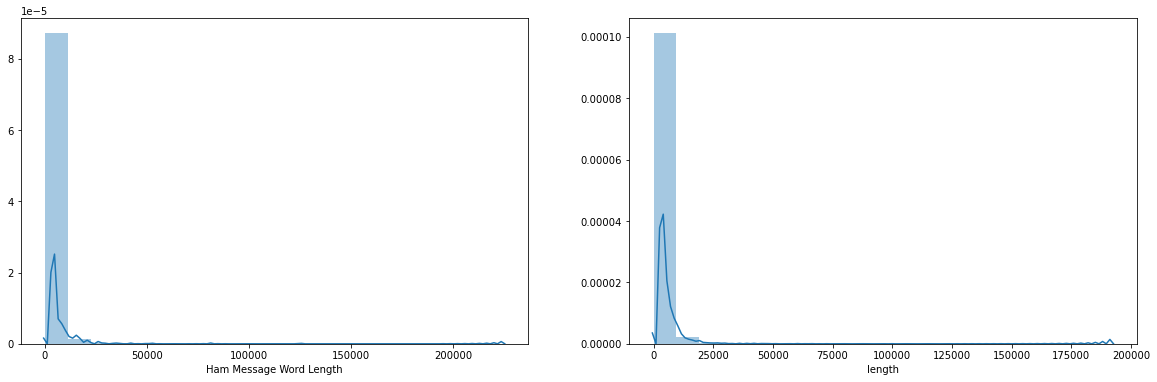

In [36]:
f, ax = plt.subplots(1, 2, figsize = (20, 6))

sn.distplot(pd.DataFrame(finalset.groupby('spam').get_group(1.0))["length"], bins = 20, ax = ax[0])
ax[0].set_xlabel("Spam Message Word Length")

sn.distplot(pd.DataFrame(finalset.groupby('spam').get_group(0.0))["length"], bins = 20, ax = ax[1])
ax[0].set_xlabel("Ham Message Word Length")

plt.show()

## Vectorization

In [34]:
#drop nan rows

In [35]:
# (*, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, analyzer='word', stop_words=None, token_pattern='(?u)\b\w\w+\b', ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.float64'>, norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False
# vec = TfidfVectorizer(max_df=0.85,ngram_range=(1,3),stop_words=stopwords,max_features=1000000)
# featuresTfidf = vec.fit_transform(finalset['text'])
# print(featuresTfidf.shape)

In [38]:
vecTfidf = TfidfVectorizer(min_df=0.0,max_df=0.85,ngram_range=(1,3))
featuresTfidf = vecTfidf.fit_transform(finalset['text'])
print(featuresTfidf.shape)

(60769, 11810266)


In [38]:
#*, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern='(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'>)[source]
# vecCount = CountVectorizer(max_df=0.85,ngram_range=(2,2),stop_words=stopwords,max_features=50000)
# featuresCount = vecCount.fit_transform(finalset['text'])
# print(featuresCount.shape)

In [91]:
vecCount = CountVectorizer(min_df=0.0,max_df=0.85,ngram_range=(1,3))
featuresCount = vecCount.fit_transform(finalset['text'])
print(featuresCount.shape)

(60769, 11542442)


## Training and testing set

In [92]:
y = finalset['spam']

In [93]:
x_trainset, x_testset, y_trainset, y_testset = train_test_split(featuresCount,y,stratify=y, test_size=0.3, random_state=0)

Save test set into csv file

In [77]:
train=pd.DataFrame(x_trainset1)
train['spam']=y_trainset1
test=pd.DataFrame(x_testset1)
test['spam']=y_testset1
train.to_csv(DATA_PATH + "lithoTrainingData.csv", index = False, header=True)
test.to_csv(DATA_PATH + "lithoTestData.csv", index = False, header=True)
# lithotest = pd.read_csv(DATA_PATH + "lithoTestData.csv")
# lithotest.head()
# lithoTrainingData = pd.read_csv(DATA_PATH + "lithoTrainingData.csv")
# lithoTrainingData.head()

In [119]:
x_trainset.shape

(42538, 11542442)

In [120]:
x_testset.shape

(18231, 11542442)

In [128]:
col=["text","spam"]
finalTest=pd.read_csv(DATA_PATH + "lithoTestData.csv")
finalTest.shape

(5465, 2)

In [127]:
finalTest = finalTest.dropna()
finalTest.to_csv(DATA_PATH + "lithoTestData.csv", index = False, header=True)
finalTest.shape

(5465, 2)

## Modeling - Cross validation

In [147]:
#10K fold data Logistic regression model
from sklearn.model_selection import cross_val_predict
def crossValidatorFunction(model):
    kf = StratifiedKFold(n_splits=10, shuffle = True, random_state=42)
    model.fit(x_trainset,y_trainset)
    y_model_train_pred = cross_val_predict(model, x_trainset, y_trainset, cv=kf)
    print("F1 Score train: ",f1_score(y_trainset, y_model_train_pred))
    y_model_test_pred = model.predict(x_testset)
    print("F1 Score test: ",f1_score(y_testset, y_model_test_pred))

## DecisionTree

In [163]:
kf = StratifiedKFold(n_splits=10, shuffle = True, random_state=42)
dtc = DecisionTreeClassifier(random_state=42, max_features='sqrt')
dtc.fit(x_trainset,y_trainset)
y_dtc_train_pred = cross_val_predict(dtc, x_trainset, y_trainset, cv=kf)
print("DecisionTree F1 Score train: ",f1_score(y_trainset, y_dtc_train_pred))

y_dtc_test_pred = dtc.predict(x_testset)
print("DecisionTree F1 Score test: ",f1_score(y_testset, y_dtc_test_pred))
pickle.dump(dtc,open('decisionTree_new.pkl','wb'))

DecisionTree F1 Score train:  0.819842437884166
DecisionTree F1 Score test:  0.8295247724974723


## Random forest

In [165]:
#n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None
# X, y = make_classification(n_samples=1000, n_features=50000,n_informative=2, n_redundant=0,random_state=0, shuffle=False)
rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_features='sqrt', verbose=True)
rfc.fit(x_trainset,y_trainset)
y_rfc_train_pred = cross_val_predict(rfc, x_trainset, y_trainset, cv=kf)
print("Random forest F1 Score train: ",f1_score(y_trainset, y_rfc_train_pred))

y_rfc_test_pred = rfc.predict(x_testset)
print("Random forest F1 Score test: ",f1_score(y_testset, y_rfc_test_pred))
pickle.dump(rfc,open('randomForest_new.pkl','wb'))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 26.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 23.5min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 22.7min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.0s
[Paral

Random forest F1 Score train:  0.8892221180880975


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   13.0s finished


Random forest F1 Score test:  0.89295836058426


## XGboost

In [166]:
xgb1_model=xgb.XGBClassifier(objective="binary:logistic", random_state=42, n_estimators=100, n_jobs=-1)
xgb1_model.fit(x_trainset,y_trainset)
y_xgb_train_pred = cross_val_predict(xgb1_model, x_trainset, y_trainset, cv=kf)
print("XGBoost F1 Score train: ",f1_score(y_trainset, y_rfc_train_pred))

y_xgb_test_pred = xgb1_model.predict(x_testset)
print("XGBoost F1 Score test: ",f1_score(y_testset, y_xgb_test_pred))
pickle.dump(xgb1_model,open('xgBoost_new.pkl','wb'))

XGBoost F1 Score train:  0.8892221180880975
XGBoost F1 Score test:  0.9002624671916011


In [50]:
x_testset.shape

(18231, 11542442)

## LightGB

In [ ]:
lgb = LGBMClassifier(objective="binary",random_state=42,n_jobs=-1,n_estimators=10,max_features='sqrt', verbose=1)
lgb.fit(x_trainset,y_trainset)
y_lgb_train_pred = cross_val_predict(lgb, x_trainset, y_trainset, cv=kf)
print("LightGB F1 Score train: ",f1_score(y_trainset, y_rfc_train_pred))

y_lgb_test_pred = lgb.predict(x_testset)
print("LightGB F1 Score test: ",f1_score(y_testset, y_lgb_test_pred))
pickle.dump(lgb,open('LightGB_new.pkl','wb'))

## Pickle

In [34]:
pickle.dump(vecTfidf,open('vectorizationTfIdf.pkl','wb'))
pickle.dump(vecCount,open('vectorizationCount.pkl','wb'))

NameError: name 'vecTfidf' is not defined